# Public data exploration

The objective of this notebook is to explore some public dataset that may be used to feed a realistic dataset of care trajectories.

We explore datasets that can help to create a realistic population of patient (bases on demographic datasets) and datasets about care deliveries.

There are two main sources of the datasets:

- the Ministry of Health that provides aggregate statistics from the SNIIRAM database about the cares. This figures are very interesting in our case because it contains statistics coming from the original data we are mimicing.
- the INSEE (french national institute of statistics). It provides useful information about the french population demography.

<span style="color:orange;">**WARNING**: data are sometimes huge! I did not save them in the Git repository. For each experiment, the source of the data are given and assumed to be saved in the `../data` repository.</span>


## Preliminaries
Some library import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import zipfile

## Open medic dataset
source: https://www.data.gouv.fr/fr/datasets/open-medic-base-complete-sur-les-depenses-de-medicaments-interregimes/

Open medic is a dataset which contains aggregated counts of deliveries of medics to the French population. It originates from the SNIIRAM dataset. There is no information about the location of drug deliveries or location of beneficiaries.

Load the open medic CSV dataset from the zip file thanks to the pandas library!

In [2]:
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")
#remove labels of drugs (just keep the codes)
try:
    del(data['l_ATC1'])
    del(data['L_ATC2'])
    del(data['L_ATC3'])
    del(data['L_ATC4'])
    del(data['L_ATC5'])
    del(data['l_cip13'])
except:
    pass

In [3]:
#show the first rows of the dataset
data

,ATC1,ATC2,ATC3,ATC4,ATC5,CIP13,TOP_GEN,GEN_NUM,age,sexe,BEN_REG,PSP_SPE,BOITES,REM,BSE
0,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,1,113,"53,31","191,53"
1,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,12,152,"77,60","258,68"
2,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,90,74,"33,50","126,72"
3,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,98,13,"6,56","21,87"
4,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,11,1,106,"39,47","136,74"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829854,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,1,19,"1.293,64","1.480,72"
1829855,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,3,260,"17.739,10","20.321,06"
1829856,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,90,125,"7.785,87","9.790,24"
1829857,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,99,27,"1.607,05","2.091,60"


The dataset gives the number of drug boxes delivered (in pharmacies, not in hospitals) 

Description of the columns

- `CIP13` is the barcode of the drug box
- `ATC5` is the classification of the drug (active component) in the international ATC taxonomy (ATC1 to ATC4 are the sublevels) 
- `age` is a class of ages of the beneficiaries  (0, 20, 60 or 99)
- `sexe` is the sexe of the beneficiaries 
- `BEN_REG` region of the beneficiaries
- `TOP_GEN` generic-brand {'0', '9', 'G', 'R', 'S'}
- `TOP_GEN` generic group (0 if none)
- `PSP_SPE` speciality of the prescriber
- `BOITES` total of drug boxes that have been delivered during year 2019 to people of given sex, in given age group with a given regime by a given prescriber's specialty
- `REM` and `BSE` are related to the costs


In [4]:
print("TOP_GEN: "+str(set(data['TOP_GEN'])))
print("GEN_NUM: "+str(set(data['GEN_NUM'])))
print("age: "+str(set(data['age'])))
print("sexe: "+str(set(data['sexe'])))
print("BEN_REG: "+str(set(data['BEN_REG'])))
print("PSP_SPE: "+str(set(data['PSP_SPE'])))


TOP_GEN: {'9', '0', 'S', 'R', 'G'}
GEN_NUM: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 43, 45, 50, 51, 54, 55, 56, 57, 59, 60, 65, 66, 67, 68, 69, 70, 71, 72, 73, 78, 79, 80, 81, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 108, 117, 118, 119, 120, 124, 125, 126, 127, 128, 129, 130, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166, 167, 168, 170, 171, 174, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 201, 202, 203, 205, 206, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 230, 231, 233, 234, 237, 238, 239, 240, 241, 242, 243, 245, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 271, 272, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 293, 294, 295, 296

Remove some useless colums, and gather some lines togethers

In [5]:
try:
    del(data['ATC1'])
    del(data['ATC2'])
    del(data['ATC3'])
    del(data['ATC4'])
    del(data['TOP_GEN'])
    del(data['GEN_NUM'])
    del(data['REM'])
    del(data['BSE'])
except:
    pass

## The following lines keep only the meaningful dimensions
drugs=data.groupby(["age","sexe","BEN_REG","ATC5","CIP13"]).agg({"BOITES":["sum"]}) #compute a group object
drugs = drugs.reset_index() #transform the group object into a dataframe
drugs.columns = drugs.columns.get_level_values(0)
print("Number of lines: %d"%len(drugs))



Number of lines: 560725


In [6]:
#show the data sorted by descending order of the number of boxes
drugs.sort_values( by=["BOITES"], ascending=False )

,age,sexe,BEN_REG,ATC5,CIP13,BOITES
214636,20,2,11,N02BE01,3400935955838,9447008
444582,60,2,11,N02BE01,3400935955838,7292659
103242,20,1,11,N02BE01,3400935955838,6732939
328210,60,1,11,N02BE01,3400935955838,5281624
531075,60,2,84,N02BE01,3400935955838,4833604
...,...,...,...,...,...,...
199404,20,1,99,N02BE71,3400949605538,-512
313231,20,2,99,N02AX52,3400922096032,-579
199402,20,1,99,N02BE71,3400935154958,-613
197993,20,1,99,J01DH51,3400938337006,-653


Some remarks
- I have few negative counts

### Normalized drug deliveries counts

In [7]:
## Drugcounts evaluates the total number of deliveries per age and sex (what ever the drug)

# Remove negative counts
drugs=drugs[drugs['BOITES']>0]

#Evaluated the totals of drug deliveries per age and per sex
drugcounts=drugs.groupby(["age","BEN_REG","sexe"]).agg({"BOITES":["sum"]})
drugcounts = drugcounts.reset_index() #transform the group object into a dataframe
drugcounts.columns = drugcounts.columns.get_level_values(0)
drugcounts.rename( columns={'BOITES':'count'}, inplace=True)

In [8]:
drugcounts

,age,BEN_REG,sexe,count
0,0,0,1,5823
1,0,0,2,5487
2,0,5,1,3542864
3,0,5,2,3855072
4,0,11,1,17163715
...,...,...,...,...
112,99,93,2,147424
113,99,93,9,267
114,99,99,1,117909
115,99,99,2,98191


In [9]:
# We now compute the frequency of the deliveries for each drug per group of sex and age
drug_freq=pd.merge(drugs,drugcounts,how='left', on=['age','BEN_REG','sexe'])
drug_freq['p']=drug_freq['BOITES']/drug_freq['count']
drug_freq

,age,sexe,BEN_REG,ATC5,CIP13,BOITES,count,p
0,0,1,0,A02BC05,3400938673081,32,5823,0.005495
1,0,1,0,A02X,3400931923077,31,5823,0.005324
2,0,1,0,A03AA05,3400934104831,37,5823,0.006354
3,0,1,0,A03AX12,3400930986080,13,5823,0.002233
4,0,1,0,A03AX12,3400931863014,51,5823,0.008758
...,...,...,...,...,...,...,...,...
560603,99,9,99,V08CA04,3400935082886,14,193624,0.000072
560604,99,9,99,V08CA04,3400935082947,11,193624,0.000057
560605,99,9,99,V08CA08,3400938879728,29,193624,0.000150
560606,99,9,99,V08CA09,3400936080218,16,193624,0.000083


In [10]:
#sauvegarde de la matrice pour réutilisation
drug_freq[['age','sexe','ATC5','BEN_REG','CIP13','p']].to_csv("drugs_freq.csv")

# Population datasets

Source: https://www.insee.fr/fr/statistiques/1893204#consulter

Datasets about population demography are provided by INSEE.
There are several dataset publicly available that may be useful:
- Sexe/Age/Quinquennal dataset provide population count by sex and city, but it is aggregated by age (5 years)
- the population dataset provides information, per yearly age and sex, of the national population. My idea is to use this dataset of redistribute the population in the 5 years group (and by sex) of people according to the national distribution of this group of people.
- population dataset maybe useful to get the zip code of cities

In [32]:
pop_saq = pd.read_csv("../data/pop-sexe-age-quinquennal.zip", header=0, sep=',', encoding="latin_1", dtype={'DR':str,'DR18':str })
pop_saq.dropna(inplace=True) #some cities disappeared leading to none lines
try:
    #remove some a priori useless columns
    #del(pop_saq['RR'])
    del(pop_saq['CR'])
    del(pop_saq['DR'])
    del(pop_saq['STABLE'])
except:
    pass

#Gather all the columns in a unique column with variables to describe them ('sex' and 'age')
pop_saq=pop_saq.melt(id_vars=['DR18','RR','LIBELLE'])
tmp=pop_saq['variable'].str.extract(r'ageq_rec(?P<age>\d+)s(?P<sex>\d)rpop2016')
pop_saq=pd.concat([tmp,pop_saq],axis=1)
pop_saq['age']=(pd.to_numeric(pop_saq['age'])-1)*5 #counts for 5 years intervals of ages
del(tmp)
del(pop_saq['variable'])

#rename columns
pop_saq=pop_saq.rename(columns={'LIBELLE':'Ville', 'DR18':'dpt'})
pop_saq['Ville']=pop_saq['Ville'].str.lower()

pop_saq

FileNotFoundError: [Errno 2] No such file or directory: '../data/pop-sexe-age-quinquennal.zip'

Note that I don't know yet why there are real-valued counts !!

In [12]:
pop_saq['RR'].unique()

array([84, 32, 93, 44, 76, 28, 75, 24, 27, 53, 94, 52, 41, 11,  1,  2,  3,
        4])

In [13]:
pop_france = pd.read_csv("../data/pop-totale-france-metro.zip", header=0, sep=',', encoding="latin_1")
del(pop_france["Année de naissance"])
del(pop_france["Ensemble"])
pop_france.rename(columns={"Âge révolu":"age", "Nombre d'hommes":"male", "Nombre de femmes":"female"}, inplace=True)
pop_france

,age,male,female
0,0,343009,329909
1,1,348625,333151
2,2,354653,340515
3,3,366334,350669
4,4,376914,360433
...,...,...,...
102,102,367,2490
103,103,241,1396
104,104,212,946
105,105 ou plus,638,2060


In [14]:
pop_cities = pd.read_csv("../data/population.zip", header=0, sep=';', encoding="utf-8")
pop_cities['dpt'] = pop_cities['Code'].str[:-3].str.pad(width=2, fillchar='0')
pop_cities

,Code,Ville,Population2016,dpt
0,1001,L'Abergement-Clémenciat,767.0,01
1,1002,L'Abergement-de-Varey,243.0,01
2,1004,Ambérieu-en-Bugey,14081.0,01
3,1005,Ambérieux-en-Dombes,1671.0,01
4,1006,Ambléon,110.0,01
...,...,...,...,...
34963,97613,M'Tsangamouji,NaN,97
34964,97614,Ouangani,NaN,97
34965,97615,Pamandzi,NaN,97
34966,97616,Sada,NaN,97


In [15]:
#tentative de récupération des codes commune ... 
# mais les libellés ne correspondent pas exactement (des l' par exemple)
pop_cities['Ville']=pop_cities['Ville'].str.lower()
# on arrange déjà en enlevant certains "l'" en début
pop_cities['Ville']=pop_cities['Ville'].str.replace(pat="^l'",repl="")
pop_cities['Ville']=pop_cities['Ville'].str.replace(pat="^la ",repl="")
pop_cities['Ville']=pop_cities['Ville'].str.replace(pat="^le ",repl="")
pop_cities['Ville']=pop_cities['Ville'].str.replace(pat="^les ",repl="")
pop_cities['Ville']=pop_cities['Ville'].str.replace(pat="œ",repl="?")

pop=pd.merge(pop_saq,pop_cities,how='left', on=('dpt','Ville'))
del(pop['Population2016'])
print(pop.columns)

pop['sex']=pop['sex'].astype('int32')
print(pop.dtypes)

unmatches=pop["Code"].isna().sum()/40
print("Estimated number of cities without code matching: %d"%(unmatches))


Index(['age', 'sex', 'dpt', 'RR', 'Ville', 'value', 'Code'], dtype='object')
age        int64
sex        int32
dpt       object
RR         int64
Ville     object
value    float64
Code      object
dtype: object
Estimated number of cities without code matching: 775


In [16]:
np.sum(pop['value'])

66360472.16497998

In [17]:
pop.head()

,age,sex,dpt,RR,Ville,value,Code
0,0,1,01,84,abergement-clémenciat,15.000000,1001
1,0,1,01,84,abergement-de-varey,5.000000,1002
2,0,1,01,84,ambérieu-en-bugey,529.591402,1004
3,0,1,01,84,ambérieux-en-dombes,25.555140,1005
4,0,1,01,84,ambléon,5.000000,1006


In [18]:
pop['Code'].str[-3:]

0          001
1          002
2          004
3          005
4          006
          ... 
1416195    NaN
1416196    NaN
1416197    NaN
1416198    NaN
1416199    NaN
Name: Code, Length: 1416200, dtype: object

In [19]:
#pop_cities[pop_cities['Ville'].str.contains("bellegarde")]

In [20]:
pop.to_csv("pop.csv")

In [98]:
#from IPython.core.display import HTML
#df=pop[ (pop['Code'].isnull()) & (pop['age']==0) & (pop['sex']==1) ]
#display(HTML(df.to_html()))

In [99]:
# few processing to prepare a dataset for master Telenvi
popagg=pop_cities
dpt=[s[:(len(s)-3)] for s in popagg["Code"]]
popagg["Code"]=dpt

popagg=popagg.groupby(["Code"]).agg({"Population2016":["sum"]})

popagg.reset_index(inplace=True)
popagg.columns = popagg.columns.get_level_values(0)
popagg

popagg.to_csv('population.csv',index=False)

In [21]:
#print(popagg)

## Lets try to generate a synthetic drugs deliveries for population of Ille-et-Vilaine

### Generating a synthetic population in Ille et Vilaine

We would like to have 10000 peoples (with age above >15) that would respect the following dataset characteristics

- geographical distribution (at the level of the cities of Ille-et-Vilaine)
- gender distribution for each city
- age distribution 

In [100]:
import numpy.random as rd

pop35 = pop[ (pop["dpt"]=="35") & (pop['age']>=15)]
#print(pop35)
print(pop35[pop35["Code"].isna()]["Ville"].unique())
print("(Estimated) number of cities that disappeared from the dataset: %d."%(pop35["Code"].isna().sum()/40))      

#remove matching for cities having the same name, but not in the same departement
pop35=pop35[ pop35["Code"].str.zfill(5).str[:2]==pop35["dpt"] ]

pop35["freq"] = pop35["value"]/sum(pop35["value"])
#pop35.iloc(Index[0])

['antrain' 'baillé' 'chancé' 'dompierre-du-chemin' 'fontenelle' 'lanhélin'
 'luitré' 'piré-sur-seiche' 'saint-georges-de-chesné'
 'saint-jean-sur-couesnon' 'saint-marc-sur-couesnon' "saint-m'hervon"
 'saint-ouen-la-rouërie' 'saint-père' 'saint-pierre-de-plesguen'
 'tremblay' 'tressé' 'vendel']
(Estimated) number of cities that disappeared from the dataset: 15.


In [101]:
#generation of a synthetic population of size `synth_pop_size`
synth_pop_size=10000
Index=rd.choice(np.array(pop35.index), synth_pop_size, p=np.array(pop35["freq"]), replace=True)

synthpop=pop35.loc[Index]
synthpop.reset_index(inplace=True)

del(synthpop['value'])
del(synthpop['freq'])
synthpop['age'] = synthpop['age']+rd.randint(0,5,size=len(synthpop))


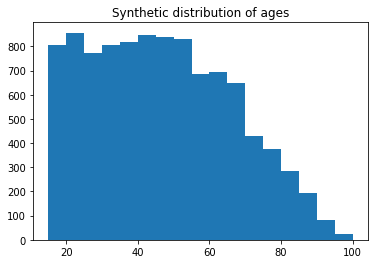

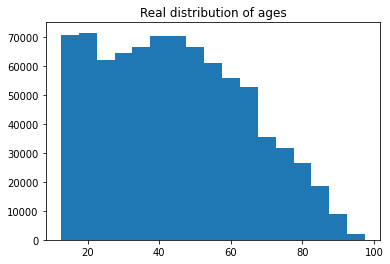

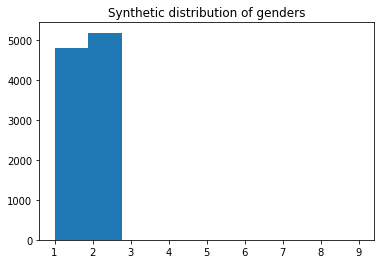

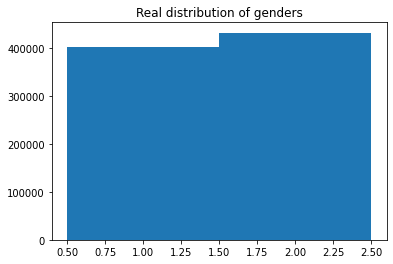

In [102]:
#### Distribution of ages
plt.hist(synthpop['age'],range=(15,100),bins=17)
plt.title("Synthetic distribution of ages")
plt.show()


page=pop35.groupby(['age']).agg({'value':"sum"})
plt.figure()
plt.bar(page.index,page['value'],width=5)
plt.title("Real distribution of ages")
plt.show()

#### Distribution of genders
plt.figure()
plt.hist(synthpop['sex'],bins=9,range=(1,9))
plt.title("Synthetic distribution of genders")
plt.show()


page=pop35.groupby(['sex']).agg({'value':"sum"})
plt.figure()
plt.bar(page.index,page['value'],width=1)
plt.title("Real distribution of genders")
plt.show()

### Generation of drugs deliveries for the population
What we need:

- `drug_freq` the frequency of drug deliveries per age, per sex and per region
- `synthpop` the synthetic population of Ille et Vilaine

In [105]:
drugfreq_020_1 = drug_freq[ (drug_freq['age']==0) & (drug_freq['sexe']==1) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]
drugfreq_020_2 = drug_freq[ (drug_freq['age']==0) & (drug_freq['sexe']==2) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]
drugfreq_2060_2 = drug_freq[ (drug_freq['age']==20) & (drug_freq['sexe']==2) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]
drugfreq_2060_1 = drug_freq[ (drug_freq['age']==20) & (drug_freq['sexe']==1) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]
drugfreq_6090_1 = drug_freq[ (drug_freq['age']==60) & (drug_freq['sexe']==1) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]
drugfreq_6090_2 = drug_freq[ (drug_freq['age']==60) & (drug_freq['sexe']==2) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]
drugfreq_99_1 = drug_freq[ (drug_freq['age']==99) & (drug_freq['sexe']==1) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]
drugfreq_99_2 = drug_freq[ (drug_freq['age']==99) & (drug_freq['sexe']==2) ][['age','sexe','BOITES','BEN_REG','CIP13','p']]

In [115]:
drugfreq_020_1.head()

,age,sexe,BEN_REG,CIP13,p
0,0,1,0,3400938673081,0.005495
1,0,1,0,3400931923077,0.005324
2,0,1,0,3400934104831,0.006354
3,0,1,0,3400930986080,0.002233
4,0,1,0,3400931863014,0.008758


In [129]:
pop_saq.head()

,age,sex,dpt,RR,Ville,value
0,0,1,01,84,abergement-clémenciat,15.000000
1,0,1,01,84,abergement-de-varey,5.000000
2,0,1,01,84,ambérieu-en-bugey,529.591402
3,0,1,01,84,ambérieux-en-dombes,25.555140
4,0,1,01,84,ambléon,5.000000


In [130]:
pop_saq[ (pop_saq["RR"]==84) & (pop_saq["age"]>=0) & (pop_saq["age"]< 20) & (pop_saq['sex']=="1") ]

,age,sex,dpt,RR,Ville,value
0,0,1,01,84,abergement-clémenciat,15.000000
1,0,1,01,84,abergement-de-varey,5.000000
2,0,1,01,84,ambérieu-en-bugey,529.591402
3,0,1,01,84,ambérieux-en-dombes,25.555140
4,0,1,01,84,ambléon,5.000000
...,...,...,...,...,...,...
242030,15,1,74,84,viuz-en-sallaz,110.000000
242031,15,1,74,84,vougy,67.446541
242032,15,1,74,84,vovray-en-bornes,20.000000
242033,15,1,74,84,vulbens,35.561562


#### Compute the mean number of deliveries per patient

The number of deliveries can be obtained by computing the total number of drug boxes delivered for a group of patients (per age and sex) divided by the total amount of people in this group (known through `pop_saq`)

In [164]:
regions = [84, 32, 93, 44, 76, 28, 75, 24, 27, 53, 94, 52, 41, 11,  1,  2,  3, 4]
#94 ?? (pas dans la notice!!)
#1,2,3,4??
#manque 0 (inconnu) et 5 (régions et dpt outermer) et 41 ??
regions = [84, 32, 93, 44, 76, 28, 75, 24, 27, 53, 52, 41, 11]
sexes = ["1","2"]
ages=[(0,20), (20,60),(60,95),(95,150) ]

index = pd.MultiIndex.from_product([ages, regions, sexes], names = ["age", "rr", 'sex'])
mean_deliveries=pd.DataFrame(index = index)
mean_deliveries['mean']=float(0)

for r in regions:
    for s in sexes:
        for age in ages:
            cpop=np.sum(pop_saq[ (pop_saq["RR"]==r) & (pop_saq["age"]>=age[0]) & (pop_saq["age"]< age[1]) & (pop_saq['sex']==s) ]['value'])
            if age[0]==95:
                a=99
            else:
                a=age[0]
            if cpop!=0:
                mean_deliveries.loc[age,r,s]['mean']=np.sum(drug_freq[ (drug_freq['age']==a) & (drug_freq['sexe']==int(s)) & (drug_freq['BEN_REG']==r) ]['BOITES'])/cpop
mean_deliveries.reset_index(inplace=True)
mean_deliveries['age']=mean_deliveries['age'].apply(lambda x: x[0])

In [165]:
mean_deliveries[mean_deliveries['rr']==52]

,age,rr,sex,mean
20,0,52,1,8.724413
21,0,52,2,9.881782
46,20,52,1,18.167009
47,20,52,2,25.130377
72,60,52,1,65.283829
73,60,52,2,71.726552
98,95,52,1,0.000000
99,95,52,2,0.209182


In [166]:
#on sauvegarde ces infos
mean_deliveries.to_csv("mean_deliveries.csv")

#### Generating deliveries

In [70]:

def generate(p):
    if p['age']<20:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=10.88,scale=5)))
            drugs=rd.choice(np.array(drugfreq_020_1['CIP13']), nb, p=np.array(np.array(drugfreq_020_1['p'])), replace=True)
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=11.97,scale=5)))
            drugs=rd.choice(np.array(drugfreq_020_2['CIP13']), nb, p=np.array(np.array(drugfreq_020_2['p'])), replace=True)
            return drugs
    elif p['age']<40:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=21.56,scale=10)))
            drugs=rd.choice(np.array(drugfreq_2060_1['CIP13']), nb, p=np.array(np.array(drugfreq_2060_1['p'])), replace=True)
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=29.88,scale=10)))
            drugs=rd.choice(np.array(drugfreq_2060_2['CIP13']), nb, p=np.array(np.array(drugfreq_2060_2['p'])), replace=True)
            return drugs
    elif p['age']<95:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=72.53,scale=10)))
            drugs=rd.choice(np.array(drugfreq_6090_1['CIP13']), nb, p=np.array(np.array(drugfreq_6090_1['p'])), replace=True)
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=79.13,scale=10)))
            drugs=rd.choice(np.array(drugfreq_6090_2['CIP13']), nb, p=np.array(np.array(drugfreq_6090_2['p'])), replace=True)
            return drugs
    else:
        if p['sex']==1 and len(drugfreq_90_1['CIP13'])>0:
            nb=int(np.abs(rd.normal(loc=16.04,scale=10)))
            drugs=rd.choice(np.array(drugfreq_90_1['CIP13']), nb, p=np.array(np.array(drugfreq_90_1['p'])), replace=True)
            return drugs
        elif p['sex']==2 and len(drugfreq_90_2['CIP13'])>0 :
            nb=int(np.abs(rd.normal(loc=4.03,scale=10)))
            drugs=rd.choice(np.array(drugfreq_90_2['CIP13']), nb, p=np.array(np.array(drugfreq_90_2['p'])), replace=True)
            return drugs
        else:
            return []
        
print("generate")
df=synthpop.apply(generate, axis=1)
print("stacking")
deliveries = df.apply(pd.Series).stack().reset_index(drop=True)
print("done")

generate
stacking
done


In [71]:
### VERSION BEAUCOUP PLUS LENTE ()

def generate(p):
    if p['age']<20:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=20,scale=5)))
            drugs=drugfreq_020_1.sample(nb, weights='p',replace=True)['CIP13']
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=20,scale=10)))
            drugs=drugfreq_020_2.sample(nb, weights='p',replace=True)['CIP13']
            return drugs
    elif p['age']<40:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=50,scale=10)))
            drugs=drugfreq_2060_1.sample(nb, weights='p',replace=True)['CIP13']
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=50,scale=10)))
            drugs=drugfreq_2060_2.sample(nb, weights='p',replace=True)['CIP13']
            return drugs
    elif p['age']<90:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=drugfreq_6090_1.sample(nb, weights='p',replace=True)['CIP13']
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=drugfreq_6090_2.sample(nb, weights='p',replace=True)['CIP13']
            return drugs
    else:
        if p['sex']==1 and len(drugfreq_90_1['CIP13'])>0:
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=drugfreq_90_1.sample(nb, weights='p',replace=True)['CIP13']
            return drugs
        elif p['sex']==2 and len(drugfreq_90_2['CIP13'])>0 :
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=drugfreq_90_12sample(nb, weights='p',replace=True)['CIP13']
            return drugs
        else:
            return []
        
#print("generate")
#df=synthpop.apply(generate, axis=1, result_type="expand")
#print("stacking")
#deliveries = df.apply(pd.Series).stack().reset_index(drop=True)
#print("done")

In [72]:
np.max(df.apply(lambda x: len(x)))

125

In [73]:
len(deliveries)/len(df)

54.8681

# Exploration of new datasets

The same approach can be done for other kind of cares. Open data repositories give access to two other interesting datasets: 

- OpenBio that assesses the number of biology exams
- OpenDamir that assesses the number of outpatient medical acts and visits 

This last dataset contains much more details.

## Open Bio -- Biology exams
source: https://www.data.gouv.fr/fr/datasets/open-bio-base-complete-sur-les-depenses-de-biologie-medicale-interregimes/

Dataset correspondant aux biologies: donne les denombrements (`DNB`) de chaque actes de biologies par age, par sexe, par régime et par spécialisation du prescripteur.


In [152]:
import pandas as pd
biology = pd.read_csv("../data/OPEN_BIO_2018.zip", header=0, sep=';', encoding="utf-8")
del(biology["L_GRP"])
del(biology["L_ACTE"])
del(biology["REM"])
del(biology["BSE"])

biology

,GRP,ACTE,AGE,SEXE,BEN_REG,PSP_SPE,DNB
0,90,4,40,2,11,6,115
1,90,4,20,2,75,7,57
2,90,4,60,2,28,7,24
3,90,4,0,1,11,99,24
4,90,4,40,1,84,90,60
...,...,...,...,...,...,...,...
320777,29,9926,0,1,11,6,12
320778,29,9926,0,1,11,1,62
320779,29,9926,0,1,5,90,47
320780,29,9926,0,1,5,6,16


In [153]:
biology.groupby(["GRP","ACTE","AGE","SEXE"]).agg({"DNB":["sum"]})

DNB
                       sum
GRP ACTE AGE SEXE         
1   1104 0   1     1125930
             2     1543738
         20  1     2544450
             2     7383140
         40  1     6374417
...                    ...
90  8000 20  2        1241
         40  1        5566
             2        2694
         60  1        6452
             2        3457

[6409 rows x 1 columns]

## Open DAMIR data

* Source fichiers R: https://www.data.gouv.fr/fr/datasets/depenses-d-assurance-maladie-hors-prestations-hospitalieres-par-caisse-primaire-departement/
* Source fichiers A: https://www.data.gouv.fr/fr/datasets/open-damir-base-complete-sur-les-depenses-dassurance-maladie-inter-regimes/

Jeu de données aggrégé sur les remboursements hors hopital. 

Le jeu indique les dénombrements de prestations (identifié par `PRS_NAT`) : `act_dnb` par CPAM (donc par departement ...), par spécialisation de l'exécutant (et son status Libéral/salarié) par TOP (?)

Il n'y a pas d'information sur les patients (sexe, age).

**En fait, ce n'est pas le jeu de données OPEN DAMIR** 
* les fichier R ... ne contiennent pas tous les détails
* il faut prendre les fichiers A 


In [195]:
#import zipfile
#import pandas as pd
#
#zip_file = zipfile.ZipFile('../data/R2019_sans_lib.zip')
#damir = [pd.read_csv(zip_file.open(text_file.filename), header=0, sep=';', encoding="latin-1") for text_file in zip_file.infolist() if text_file.filename.endswith('.csv')]

#damir = pd.read_csv("../data/R2019_sans_lib.zip", header=0, sep=';', encoding="latin-1")
#damir

In [196]:
#zip_file = zipfile.ZipFile('../data/R2019.zip')
#for text_file in zip_file.infolist():
#    print(text_file.filename)
#    #pd.read_csv(zip_file.open(text_file.filename))

In [197]:
#damir=pd.read_csv(zip_file.open("R201901.CSV"), sep=';', encoding="latin-1")


In [12]:
damir=pd.read_csv("../data/R201901.CSV", sep=';', encoding="latin-1")

/home/tguyet/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
damir.head()

,cpam,l_cpam,dpt,l_dpt,region,l_region,l_serie,SERIE,prs_nat,l_prs_nat,...,l_exe_spe1,exe_stj1,l_exe_stj1,top_slm,l_top_slm,rem_mon,rec_mon,dep_mon,act_dnb,act_coe
0,781,781-Versailles,78,78-Yvelines,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"0,00","0,00","0,00",0,"0,00"
1,751,751-Paris,75,75-Paris,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,1,1-TOP Sections Locales Mutualistes,"31,88","39,85","9,85",2,"2,00"
2,771,771-Melun,77,77-Seine-et-Marne,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"24,00","30,00","0,00",1,"1,00"
3,781,781-Versailles,78,78-Yvelines,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"432,00","540,00","0,00",18,"18,00"
4,781,781-Versailles,78,78-Yvelines,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,1,1-TOP Sections Locales Mutualistes,"24,00","30,00","9,85",1,"1,00"


In [14]:
#remove labels [the dataset can be downloaded without labels]
try:
    del(damir["l_cpam"])
    del(damir["cpam"])
    del(damir["l_dpt"])
    #del(damir["region"])
    del(damir["l_region"])
    del(damir["l_serie"])
    del(damir["l_prs_nat"])
    del(damir["l_exe_spe"])
    del(damir["l_exe_spe1"])
    del(damir["l_exe_stj1"])
    del(damir["l_top_slm"])
    del(damir["rem_mon"])
    del(damir["rec_mon"])
    del(damir["dep_mon"])
    del(damir["act_coe"])
    del(damir["asu_nat"])
    del(damir["l_asu_nat"])
    del(damir["l_cpl_cod"])
    del(damir["pre_spe"])
    del(damir["l_pre_spe"])
    del(damir["pre_spe1"])
    del(damir["l_pre_spe1"])
    del(damir["pre_stj1"])
    del(damir["l_pre_stj1"])
    del(damir["REM_TAU"])
    del(damir["l_ben_qlt"])
    del(damir["sns_date"])
    del(damir["SERIE"])
    del(damir["top_slm"])
    del(damir["ben_qlt"])
except:
    pass
damir.head()

,dpt,region,prs_nat,asu_nat,cpl_cod,ben_qlt,exe_spe,exe_spe1,exe_stj1,act_dnb
0,78,11,1098,1,0,2,1,11,1,0
1,75,11,1098,1,0,1,1,11,1,2
2,77,11,1098,1,0,1,1,11,1,1
3,78,11,1098,1,0,1,1,11,1,18
4,78,11,1098,1,0,1,1,11,1,1


On remarque qu'il manque plein d'information par rapport à la documentation ... notamment sur le sexe et l'age du bénéficiaire !
Il manque également les informations sur la catégorie de l'exécutant (Medecin, infirmier, etc)

In [16]:
damir['exe_spe'].unique()

array([ 1,  4, 34,  8,  2,  3,  7,  9, 11, 15, 31, 42,  6,  5, 35, 12, 14,
       18, 13, 38, 37, 80, 17, 32, 19, 36, 21, 30, 99, 24, 26, 28, 29, 27,
       60, 64, 65, 63])

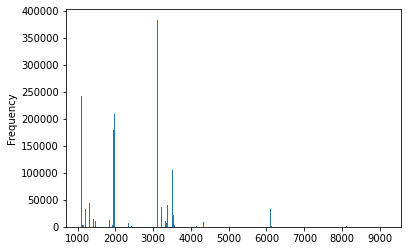

In [203]:
damir['prs_nat'].plot.hist(bins=1000)


### un peu d'analyse ...

* probabilité pour chaque type de prescription (par département)
* probabilité du spécialiste, sachant la prescription
* probabilité de la prescription, sachant le prescripteur et le département
* on vire les codes PRS qui sont après 1400 (inclus) : ce sont des codes pour des prestations "non-médicales"

In [30]:
prs_spe=damir.groupby(["dpt","prs_nat","exe_spe"]).agg({"act_dnb":["sum"]})
prs_spe.reset_index(inplace=True)
prs_spe.columns = prs_spe.columns.get_level_values(0)
#prs_spe.filter(prs_nat<1400)
prs_spe=prs_spe[prs_spe["prs_nat"]<1400]
prs_spe.head()

,dpt,prs_nat,exe_spe,act_dnb
0,01,1098,1,337
1,01,1099,1,68
2,01,1101,3,33
3,01,1101,4,64
4,01,1101,5,9


In [31]:
prs=prs_spe.groupby(["dpt","prs_nat"]).agg({"act_dnb":["sum"]})
prs.reset_index(inplace=True)
prs.columns = prs.columns.get_level_values(0)
prs.head()

,dpt,prs_nat,act_dnb
0,01,1098,337
1,01,1099,68
2,01,1101,194
3,01,1102,328
4,01,1103,10662


In [35]:
pop=pd.read_csv("pop.csv")
pop_dpt=pop.groupby('dpt').agg({"pop":'sum'})
pop_dpt.reset_index(inplace=True)
pop_dpt.columns = pop_dpt.columns.get_level_values(0)
pop_dpt.head()

/home/tguyet/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,dpt,pop
0,41,559.357862
1,42,1630.187110
2,43,514.890537
3,44,2472.319674
4,45,1425.241687


In [37]:
prs_pop=pd.merge(prs,pop_dpt,on="dpt")
prs_pop['p']=prs_pop['act_dnb']/prs_pop["pop"]
prs_pop=prs_pop[['dpt','prs_nat','p']]
prs_pop.head()

,dpt,prs_nat,act_dnb,pop,p
0,01,1098,337,638460.413502,0.000528
1,01,1099,68,638460.413502,0.000107
2,01,1101,194,638460.413502,0.000304
3,01,1102,328,638460.413502,0.000514
4,01,1103,10662,638460.413502,0.016700


Pas nécessairement très réaliste ... suppose que chaque acte se fait à une personne différente si on veut avoir la proba pour une personne ! Hors, ce n'est certainement pas le cas !

Il est peut être préférable d'avoir simplement le nombre de prestation par personne (par mois ... puisqu'on a les compte que pour 1 mois)!

In [42]:
prs_dpt=prs.groupby(["dpt"]).agg({"act_dnb":["sum"]})
prs_dpt.reset_index(inplace=True)
prs_dpt.columns = prs_dpt.columns.get_level_values(0)
prs_dpt.head()

,dpt,act_dnb
0,01,429732
1,02,420591
2,03,239794
3,04,132189
4,05,102027


In [52]:
p_prs=pd.merge(prs_dpt,pop_dpt,on="dpt")
p_prs['p']=p_prs['act_dnb']/p_prs["pop"]*12 # *12 to have a yearly number
p_prs=p_prs[['dpt','p']]
p_prs.head()

,dpt,p
0,01,8.076905
1,02,9.419085
2,03,8.486482
3,04,9.748161
4,05,8.677453


In [53]:
np.max(p_prs['p'])

14.137569897679132

In [40]:
#probability of having a PRS of nature X knowing that you live in a dpt (and that you had a PRS)
p_prs_dpt=pd.merge(prs,prs_dpt,on="dpt",suffixes=('','_dpt'))
p_prs_dpt['p']=p_prs_dpt['act_dnb']/p_prs_dpt["act_dnb_dpt"]
p_prs_dpt=p_prs_dpt[['dpt','prs_nat','p']]
p_prs_dpt.head()

,dpt,prs_nat,p
0,01,1098,0.000048
1,01,1099,0.000010
2,01,1101,0.000028
3,01,1102,0.000047
4,01,1103,0.001529


In [39]:
p_prs_dpt

,dpt,prs_nat,act_dnb,act_dnb_dpt
0,01,1098,337,6973602
1,01,1099,68,6973602
2,01,1101,194,6973602
3,01,1102,328,6973602
4,01,1103,10662,6973602
...,...,...,...,...
6131,976,1323,204,811802
6132,976,1324,2045,811802
6133,976,1331,11,811802
6134,976,1351,3097,811802


In [51]:
np.max(p_prs_dpt[ (p_prs_dpt['dpt']=="35") & (p_prs_dpt['p']>0.01) ])

dpt          35.000000
prs_nat    1110.000000
p             0.023211
dtype: float64

## Open CCAM


[https://www.scansante.fr/open-ccam/open-ccam-2016]

In [31]:
openccam=pd.read_csv("../data/Open_ccam_16.csv", sep=';', encoding="latin-1")

colname='Acte CCAM + phase' #fichier 2015
colname="acte" #fichier 2016

openccam["ccam"]=openccam[colname].str[:-1]
openccam["phase"]=openccam[colname].str[-1]
del(openccam[colname])

In [32]:
openccam

,finess,Finess géographique,nb_actes,dms,nb_sej_0_nuit,dep,reg,ccam,phase
0,10007300,010007300,21,0.000000,21,01,84,BAFA006,0
1,10007300,010007300,15,0.000000,15,01,84,BAMA004,0
2,10007300,010007300,45,0.000000,45,01,84,BELB001,0
3,10007300,010007300,465,0.000000,465,01,84,BFGA004,0
4,10007300,010007300,17,0.000000,16,01,84,GAFA007,0
...,...,...,...,...,...,...,...,...,...
348849,980500003,980500011,997,3.159391,466,98,4,ZZLP025,0
348850,980500003,980500011,313,19.840000,.,98,4,ZZQM004,0
348851,980500003,980500011,441,19.750000,.,98,4,ZZQP001,0
348852,980500003,980500011,239,24.150000,.,98,4,ZZQP003,0


In [33]:
nb_ccam=openccam.groupby(["dep","ccam"]).agg({"nb_actes":'sum'}).reset_index()
nb_ccam.head()

,dep,ccam,nb_actes
0,25,AAQM002,56
1,25,AAQP007,476
2,25,AAQP010,122
3,25,AAQP011,301
4,25,ACQH001,20


In [34]:
np.max(nb_ccam['nb_actes'])

353624

In [35]:
nb_ccam[nb_ccam['nb_actes']>100000]

,dep,ccam,nb_actes
17937,59,DEQP003,169828
17940,59,DEQP007,128721
19150,59,JVJF004,124421
20045,59,ZBQK002,224471
20111,59,ZZLP025,111722
23333,62,YYYY015,162203
23393,62,ZBQK002,115367
29291,67,DEQP003,102433
33018,69,DEQP003,100575
33021,69,DEQP007,149100


## Données AMELI

https://www.ameli.fr/l-assurance-maladie/statistiques-et-publications/donnees-statistiques/actes-techniques-de-la-ccam.php

In [3]:
actes = pd.read_excel("../data/Actes_techniques_de_la_CCAM_en_2016.xls", sheet_name='Panorama des actes CCAM')

In [4]:
actes.head()

,Code Acte,Code acte/activité/phase,Libellé long,Code Activité,Code Phase,Code Regroupement,Tarif secteur 1 et 2 adhérant au CAS,Tarif secteur 2 non adhérant au CAS,Quantité d'actes,Base de remboursement,Montants remboursés,Catégorie d'acte,Sous-catégorie d'acte
0,AAFA001,AAFA00110,Exérèse de tumeur intraparenchymateuse du cerv...,1,0,ADC,647.32,594.89,103,61572.20,61463.37,Autres Actes de Chirurgie,Actes chirurgicaux
1,AAFA001,AAFA00140,Exérèse de tumeur intraparenchymateuse du cerv...,4,0,ADA,520.24,520.24,93,48044.29,48026.29,Autres Actes de Chirurgie,Actes chirurgicaux
2,AAFA002,AAFA00240,Exérèse de tumeur intraparenchymateuse du cerv...,4,0,ADA,335.19,335.19,382,126470.37,126425.22,Autres Actes de Chirurgie,Actes chirurgicaux
3,AAFA002,AAFA00210,Exérèse de tumeur intraparenchymateuse du cerv...,1,0,ADC,603.36,525.51,446,259145.53,258807.94,Autres Actes de Chirurgie,Actes chirurgicaux
4,AAFA003,AAFA00340,"Exérèse de lésion du tronc cérébral, par crani...",4,0,ADA,498.98,498.98,9,3991.84,3991.84,Autres Actes de Chirurgie,Actes chirurgicaux


In [49]:
actes["Sous-catégorie d'acte"].unique()

array(['Actes chirurgicaux', 'Actes techniques médicaux thérapeutiques',
       'Actes techniques médicaux diagnostiques', nan,
       'Imagerie Échographie', 'Imagerie Radiographie', 'Imagerie IRM',
       'Imagerie Scintigraphie', 'Imagerie Scanographie',
       "Autres examens à visée K d'exérèse", 'Autres Actes de Chirurgie',
       'Imagerie Autre Imagerie', 'Accouchements et actes obstétricaux',
       'Autres examens de biopsie',
       'Autres examens de ganglions et chaînes lymphatiques',
       'Examen de ganglions et chaînes lymphatiques',
       'Chirurgie dentaire',
       "Examen à visée K d'exérèse du haut appareil respiratoire",
       'Actes ACP V1', 'Autres examens cytopathologiques',
       "Examen à visée K d'exérèse intrathoracique",
       "Examen de biopsie pour diagnostic d'affection non carcinologique",
       "Examen à visée K d'exérèse de la bouche ou du pharynx",
       'Soins conservateurs', 'Prothèses', 'Radiologie dentaire',
       "Autres examens à visée

In [50]:
actes["Code Regroupement"].unique()

array(['ADC', 'ADA', 'ATM', 'ADE', 'ADI', nan, 'ACO', 'END', 'AXI', 'DEN',
       'TDS', 'SDE', 'RPN', 'PDT', 'IMP', 'ICO', 'PFC', 'PAR', 'PFM',
       'PAM', 'INO'], dtype=object)

* 'ADC': Acte de chirurgie
* 'ADA': Anesthétésie
* 'ATM': Actes Médicaux Thérapeutiques
* 'ADE': Echographie
* 'ADI': Imagerie
* 'ACO': chir obstétric
* 'END': Endodontie
* 'AXI': Actes de prévention
* 'DEN': ??? (dentaire ??)
* 'TDS': (dentaire ??)
* 'SDE': (dentaire/caries ??)
* 'RPN': (dentaire/reparation prothèse ??)
* 'PDT': (dentaire/prothèse ??)
* 'IMP': (dentaire/implan ??)
* 'ICO': (dentaire/inlay-core ??)
* 'PFC': (dentaire/bridge ??)
* 'PAR': (dentaire/prothèse amovible ??)
* 'PFM': (dentaire/prothèse  ??)
* 'PAM': (dentaire/prothèse amovible ??)
* 'INO': (dentaire/caries ??)

In [70]:
actes[ actes['Code Regroupement']=="DEN" ] #Actes d'imagerie

,Code Acte,Code acte/activité/phase,Libellé long,Code Activité,Code Phase,Code Regroupement,Tarif secteur 1 et 2 adhérant au CAS,Tarif secteur 2 non adhérant au CAS,Quantité d'actes,Base de remboursement,Montants remboursés,Catégorie d'acte,Sous-catégorie d'acte
4568,HBDD001,HBDD00110,Contention d'une arcade dentaire par dispositi...,1,0,DEN,NaN,NaN,14,28.92,0.0,NaN,NaN
4569,HBDD002,HBDD00210,Contention d'une arcade dentaire par dispositi...,1,0,DEN,NaN,NaN,4,0.00,0.0,NaN,NaN
4576,HBED008,HBED00810,Réduction d'une malocclusion et/ou d'une malpo...,1,0,DEN,NaN,NaN,2,0.00,0.0,NaN,NaN
4581,HBED018,HBED01810,Réduction d'une malocclusion et/ou d'une malpo...,1,0,DEN,NaN,NaN,1,0.00,0.0,NaN,NaN
4582,HBED020,HBED02010,Réduction d'une malocclusion et/ou d'une malpo...,1,0,DEN,NaN,NaN,1,0.00,0.0,NaN,NaN
8114,LAQK006,LAQK00610,Analyse céphalométrique architecturale craniof...,1,0,DEN,NaN,NaN,0,NaN,NaN,Radiographie de la tête,Imagerie Radiographie
8115,LAQK007,LAQK00710,Analyse céphalométrique craniofaciale tridimen...,1,0,DEN,NaN,NaN,0,NaN,NaN,Radiographie de la tête,Imagerie Radiographie
8426,LBQK002,LBQK00210,Bilan de dysmorphose dento-maxillo-faciale ave...,1,0,DEN,NaN,NaN,0,NaN,NaN,NaN,NaN
8427,LBQK003,LBQK00310,Bilan de dysmorphose dento-maxillo-faciale ave...,1,0,DEN,NaN,NaN,0,NaN,NaN,NaN,NaN


In [15]:
acts = actes[['Code Acte','Code Regroupement',"Quantité d'actes "]]
acts.head()

,Code Acte,Code Regroupement,Quantité d'actes
0,AAFA001,ADC,103
1,AAFA001,ADA,93
2,AAFA002,ADA,382
3,AAFA002,ADC,446
4,AAFA003,ADA,9


In [16]:
actstot=acts.groupby(['Code Acte']).agg({"Quantité d'actes ":"sum"}).reset_index()
actstot.head()

,Code Acte,Quantité d'actes
0,AAFA001,196
1,AAFA002,828
2,AAFA003,18
3,AAFA005,17
4,AAFA006,4


## Comparaison entre les deux jeux de données

Comparaison rapide entre les données de l'ATIH 2016 et les données AMELI 2016 pour voir si les nombres d'actes concordent ...

Malheureusement, c'est très très différents:
* pour certains actes, ils sont beaucoup plus nombreux dans l'ATIH
* pour d'autres, par AMELI ! (notamment sur tous les soins dentaires, ophtalmo, etc. qui sont dans AMELI mais pas dans l'ATIH parce que réalisé dans des structures non-géré par l'ATIG)

J'imagine que pour les actes d'imageries, AMELI est plus représentatif également.

Globalement, j'ai l'impression que AMELI est plus fiable que l'ATIH!


In [36]:
nb_ccam_tot=nb_ccam.groupby(['ccam']).agg({"nb_actes":"sum"}).reset_index()
cmp_ccam = pd.merge(nb_ccam_tot,actstot, left_on="ccam", right_on="Code Acte")

In [37]:
cmp_ccam['ratio']=cmp_ccam["Quantité d'actes "]/cmp_ccam['nb_actes']

In [38]:
cmp_ccam

,ccam,nb_actes,Code Acte,Quantité d'actes,ratio
0,AAFA001,869,AAFA001,196,0.225547
1,AAFA002,4950,AAFA002,828,0.167273
2,AAFA003,44,AAFA003,18,0.409091
3,AAFA007,276,AAFA007,7,0.025362
4,AAGB001,600,AAGB001,3,0.005000
...,...,...,...,...,...
4946,ZZQX188,505659,ZZQX188,601277,1.189096
4947,ZZQX192,7684,ZZQX192,4718,0.614003
4948,ZZQX197,5735,ZZQX197,6138,1.070270
4949,ZZQX200,43896,ZZQX200,45904,1.045744


In [39]:
np.min(cmp_ccam['ratio'])

0.0

In [40]:
np.max(cmp_ccam['ratio'])

38891.852459016394

In [71]:
cmp_ccam[cmp_ccam['ratio']>100]

,ccam,nb_actes,Code Acte,Quantité d'actes,ratio
217,AHLH015,45,AHLH015,4821,107.133333
380,BBQP001,2148,BBQP001,269444,125.439479
411,BDGA005,52,BDGA005,43458,835.730769
412,BDGP002,48,BDGP002,20318,423.291667
413,BDGP003,35,BDGP003,5027,143.628571
...,...,...,...,...,...
4731,ZCQJ002,1651,ZCQJ002,317305,192.189582
4747,ZCQM007,681,ZCQM007,223897,328.776799
4749,ZCQM009,67,ZCQM009,31478,469.820896
4914,ZZQX110,43,ZZQX110,5234,121.720930


In [46]:
cmp_ccam[cmp_ccam['ratio']<.05]

,ccam,nb_actes,Code Acte,Quantité d'actes,ratio
3,AAFA007,276,AAFA007,7,0.025362
4,AAGB001,600,AAGB001,3,0.005000
10,AAKA001,865,AAKA001,5,0.005780
12,AALA004,522,AALA004,1,0.001916
13,AALB001,830,AALB001,7,0.008434
...,...,...,...,...,...
4889,ZZQN002,138063,ZZQN002,1132,0.008199
4890,ZZQP001,138096,ZZQP001,8,0.000058
4891,ZZQP003,98827,ZZQP003,4,0.000040
4892,ZZQP004,611560,ZZQP004,233,0.000381
